**MOUNT GOOGLE DRIVE**

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORT LIBRARIES**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE


**LOAD DATASET**

In [46]:
file_path = '/content/drive/MyDrive/Project/Employee Retention/Datasets/Employee Retention/Train.csv'

df = pd.read_csv(file_path)

df.head()

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,type2,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,type2,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,...,type2,1.0,4,-0.9612,-0.4537,3.0,3,8,3,0.0851
3,EID_17492,F,26.0,3,Single,Lebanon,Human Resource Management,Behavioral,4.0,3,...,type2,1.0,3,-1.8176,-0.4537,NaN,3,7,3,0.0668
4,EID_22534,F,31.0,1,Married,Springfield,Logistics,Conceptual,5.0,4,...,type3,3.0,1,0.7516,-0.4537,2.0,2,8,2,0.1827


# **DATA PREPROCESSING**

In [16]:
# Check if 'Employee_ID' column exists before attempting to drop it
if 'Employee_ID' in df.columns:
    df.drop(columns=['Employee_ID'], inplace=True)
else:
    print("Warning: 'Employee_ID' column not found, skipping drop operation.")

In [17]:
# If 'Attrition_rate' is already numeric, skip string operations
if df['Attrition_rate'].dtype == object:  # Check if dtype is object (string-like)
    df['Attrition_rate'] = df['Attrition_rate'].str.rstrip('%').astype(float) / 100
else:
    df['Attrition_rate'] = df['Attrition_rate'] * 100  # Divide by 100 if already numeric

# Handling missing values
num_cols = ['Age', 'Time_of_service', 'Pay_Scale', 'Work_Life_balance', 'VAR2', 'VAR4']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)  # Fill numerical columns with median

# Fill categorical missing values with mode BEFORE one-hot encoding
cat_cols = ['Gender', 'Relationship_Status', 'Hometown', 'Unit', 'Decision_skill_possess', 'Compensation_and_Benefits']
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True) # This is done before one hot encoding

# Encode categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)

# Standardizing numerical features
scaler = StandardScaler()
num_cols_to_scale = ['Age', 'Time_of_service', 'Time_since_promotion', 'growth_rate',
                     'Travel_Rate', 'Post_Level', 'Pay_Scale', 'Work_Life_balance',
                     'VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6', 'VAR7']
df[num_cols_to_scale] = scaler.fit_transform(df[num_cols_to_scale])

# Display processed dataset
df.head()

<ipython-input-17-a5c4bcd0b5a7>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)  # Fill numerical columns with median
<ipython-input-17-a5c4bcd0b5a7>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

,Age,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,...,Unit_R&D,Unit_Sales,Unit_Security,Decision_skill_possess_Behavioral,Decision_skill_possess_Conceptual,Decision_skill_possess_Directive,Compensation_and_Benefits_type1,Compensation_and_Benefits_type2,Compensation_and_Benefits_type3,Compensation_and_Benefits_type4
0,0.191585,4,-0.907270,1.420724,-0.892388,0.281016,-1.545154,0.483097,0.546126,1.077855,...,0,0,0,0,1,0,0,1,0,0
1,-1.170623,3,-0.809876,1.420724,-0.702036,-1.261816,0.173594,-0.003056,1.437448,-0.117864,...,0,0,0,0,0,0,0,1,0,0
2,1.402436,3,1.332800,0.550639,0.249724,-1.261816,-0.685780,0.969251,-1.236519,1.077855,...,0,0,0,0,1,0,0,1,0,0
3,-1.019267,3,-0.907270,0.550639,0.566977,0.281016,0.173594,0.969251,-1.236519,-0.117864,...,0,0,0,1,0,0,0,1,0,0
4,-0.640876,1,-0.809876,1.420724,0.947681,0.281016,0.173594,-1.947669,0.546126,-2.509301,...,0,0,0,0,1,0,0,0,1,0


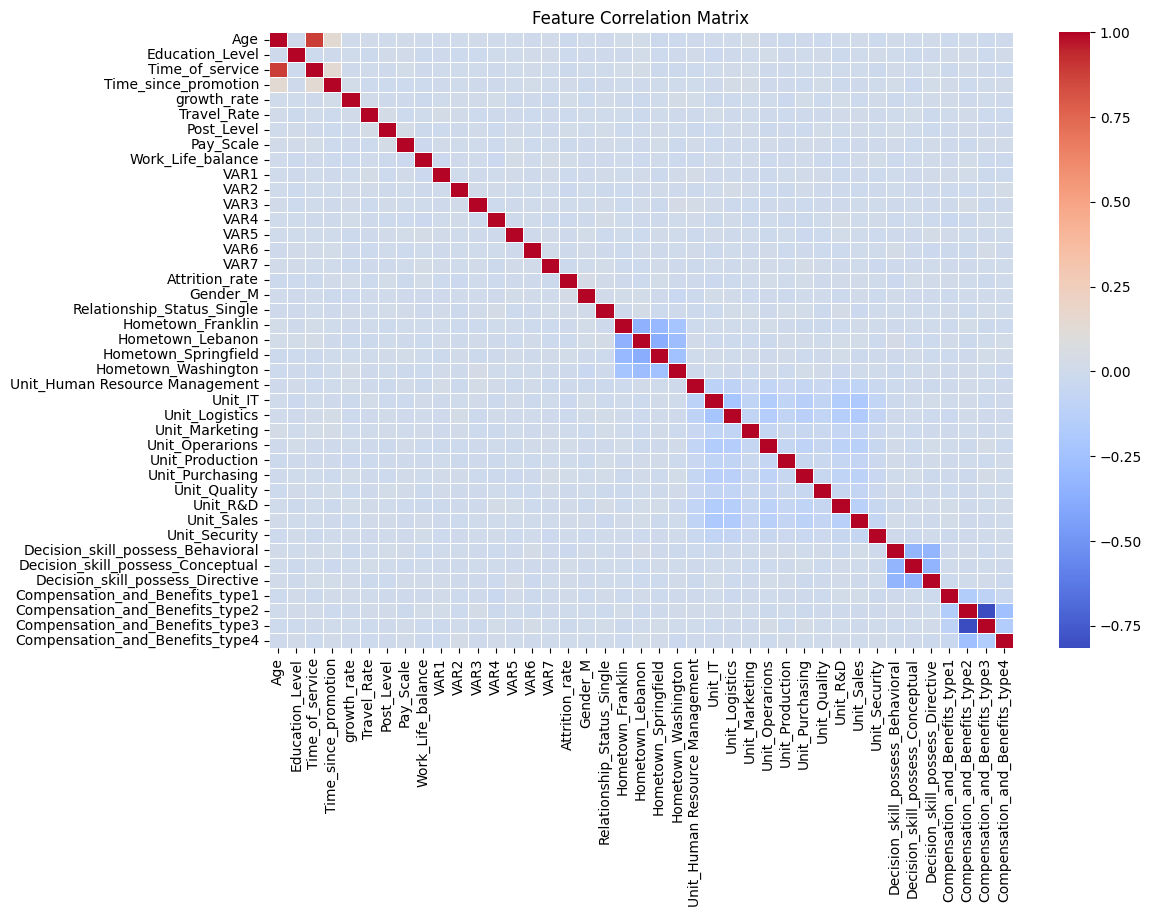

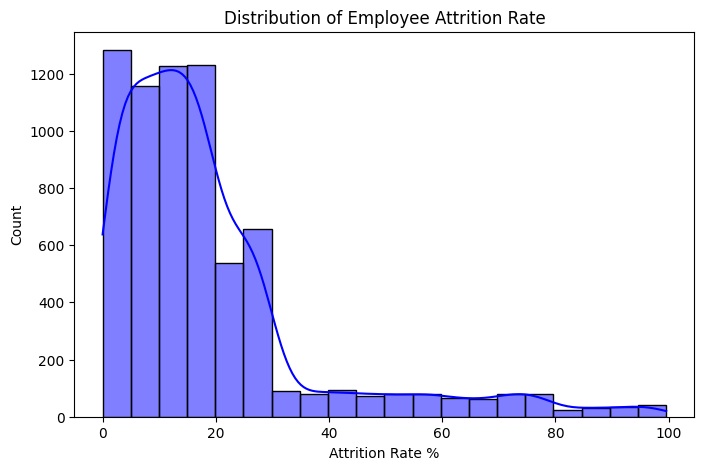

In [20]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Attrition Rate Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Attrition_rate'], bins=20, kde=True, color='blue')
plt.xlabel('Attrition Rate %')
plt.ylabel('Count')
plt.title('Distribution of Employee Attrition Rate')
plt.show()


In [21]:
X = df.drop('Attrition_rate', axis=1)

# Convert Attrition Rate into a binary classification target (1 = High Attrition, 0 = Low)
y = (df['Attrition_rate'] > 0.15).astype(int)  # Modify threshold as needed

# Convert to NumPy arrays before applying SMOTE
X = X.values
y = y.astype(int)

# Apply SMOTE with reduced impact (20% synthetic samples instead of 50%)
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame to retain column names
X_resampled = pd.DataFrame(X_resampled, columns=df.drop('Attrition_rate', axis=1).columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.78, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")


Training Data Shape: (6503, 40)
Testing Data Shape: (1835, 40)


# **CROSS-VALIDATION FUNCTION**

---



In [22]:
# Function to perform cross-validation
def cross_validate_model(model, X_train, y_train, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")


**MODEL TRAINING & BASELINE CROSS-VALIDATION**

In [23]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {roc_auc:.2f}")

print("\nLogistic Regression:")
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
evaluate_model(logreg, X_test, y_test)

print("\nDecision Tree Classifier:")
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
dt.fit(X_train, y_train)
evaluate_model(dt, X_test, y_test)

print("\nRandom Forest Classifier:")
rf = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=10, min_samples_leaf=4, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

print("\nXGBoost Classifier:")
xgb_model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.03, max_depth=3, subsample=0.7, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test)



Logistic Regression:

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.03      0.06       331
           1       0.82      0.99      0.90      1504

    accuracy                           0.82      1835
   macro avg       0.63      0.51      0.48      1835
weighted avg       0.75      0.82      0.75      1835

Accuracy: 0.82
Precision: 0.82
Recall: 0.99
F1 Score: 0.90
AUC-ROC: 0.51

Decision Tree Classifier:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       331
           1       0.92      1.00      0.96      1504

    accuracy                           0.93      1835
   macro avg       0.95      0.81      0.86      1835
weighted avg       0.93      0.93      0.92      1835

Accuracy: 0.93
Precision: 0.92
Recall: 1.00
F1 Score: 0.96
AUC-ROC: 0.81

Random Forest Classifier:

Classification Report:
              precision    recall  f1-score   suppor

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:11:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# **HYPERPARAMETER TUNING FOR RANDOM FOREST & XGBOOST**

**FEATURE IMPORTANCE ANALYSIS**

<Axes: title={'center': 'Top 10 Important Features'}>

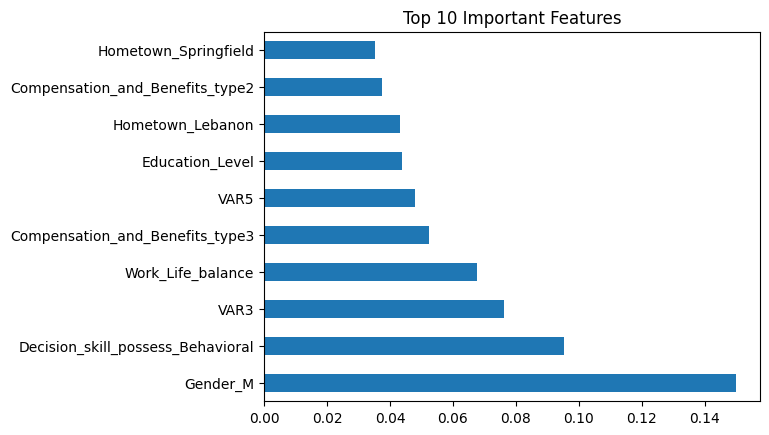

In [24]:
feature_importance = pd.Series(rf.feature_importances_, index=df.drop('Attrition_rate', axis=1).columns)
feature_importance.nlargest(10).plot(kind='barh', title="Top 10 Important Features")


# **MACHINE LEARNING MODEL TRAINING & EVALUATION**


Optimized Random Forest Classifier:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.65      0.79       331
           1       0.93      1.00      0.96      1504

    accuracy                           0.94      1835
   macro avg       0.96      0.82      0.87      1835
weighted avg       0.94      0.94      0.93      1835

Accuracy: 0.94
Precision: 0.93
Recall: 1.00
F1 Score: 0.96
AUC-ROC: 0.82


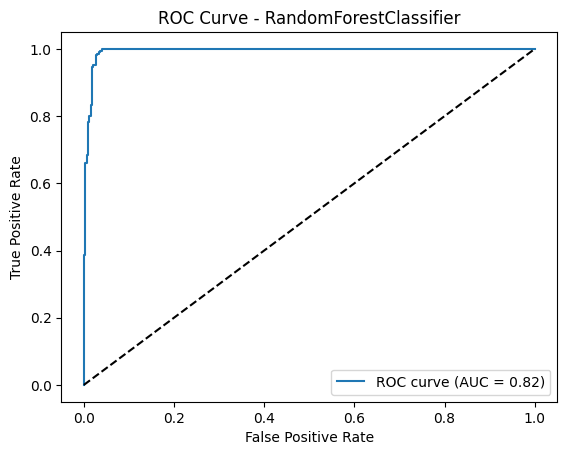


Optimized XGBoost Classifier:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60       331
           1       0.89      1.00      0.94      1504

    accuracy                           0.90      1835
   macro avg       0.94      0.71      0.77      1835
weighted avg       0.91      0.90      0.88      1835

Accuracy: 0.90
Precision: 0.89
Recall: 1.00
F1 Score: 0.94
AUC-ROC: 0.71


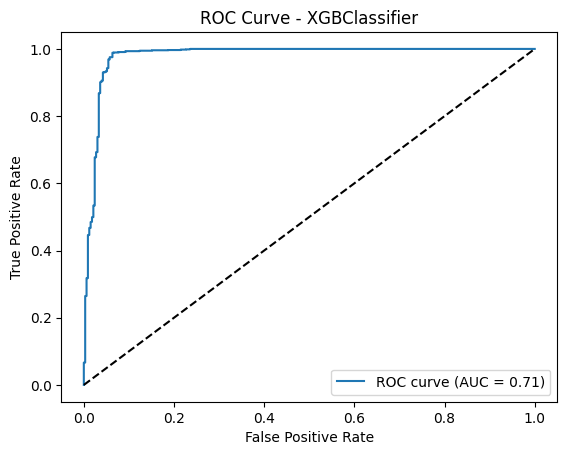

In [25]:
def plot_roc_curve(model, X_test, y_test):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = roc_auc_score(y_test, model.predict(X_test))

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {type(model).__name__}")
    plt.legend(loc="best")
    plt.show()

print("\nOptimized Random Forest Classifier:")
evaluate_model(rf, X_test, y_test)
plot_roc_curve(rf, X_test, y_test)

print("\nOptimized XGBoost Classifier:")
evaluate_model(xgb_model, X_test, y_test)
plot_roc_curve(xgb_model, X_test, y_test)

In [52]:
import joblib

# Save the trained Random Forest model
model_path = '/content/drive/MyDrive/Project/Employee Retention/Employee Retetion - RF Model (Final).joblib'
joblib.dump(rf, model_path)

print(f"Model saved to: {model_path}")

# Save the trained Decision Tree model
model_path = '/content/drive/MyDrive/Project/Employee Retention/Employee Retetion - DT Model (Final).joblib'
joblib.dump(dt, model_path)

print(f"Model saved to: {model_path}")

# Save the trained Decision Tree model
model_path = '/content/drive/MyDrive/Project/Employee Retention/Employee Retetion - XGB Model (Final).joblib'
joblib.dump(xgb_model, model_path)

print(f"Model saved to: {model_path}")

# Save the trained Decision Tree model
model_path = '/content/drive/MyDrive/Project/Employee Retention/Employee Retetion - LogReg Model (Final).joblib'
joblib.dump(logreg, model_path)

print(f"Model saved to: {model_path}")


Model saved to: /content/drive/MyDrive/Project/Employee Retention/Employee Retetion - RF Model (Final).joblib
Model saved to: /content/drive/MyDrive/Project/Employee Retention/Employee Retetion - DT Model (Final).joblib
Model saved to: /content/drive/MyDrive/Project/Employee Retention/Employee Retetion - XGB Model (Final).joblib
Model saved to: /content/drive/MyDrive/Project/Employee Retention/Employee Retetion - LogReg Model (Final).joblib


# **TESTING WITH SAMPLE INPUTS**

In [54]:
import numpy as np
import pandas as pd
import joblib

# Load the trained RandomForest model
model_path = '/content/drive/MyDrive/Project/Employee Retention/Employee Retetion - RF Model (Final).joblib'
rf_model = joblib.load(model_path)

# Retrieve exact feature names used during model training
correct_feature_order = rf_model.feature_names_in_

# Print expected feature count
print(f"Model expects {len(correct_feature_order)} features")

# Define a sample input ensuring it matches the expected feature names
sample_dict = {feature: 0 for feature in correct_feature_order}  # Default all features to 0

# Manually set values for relevant features
sample_dict.update({
    "Age": 45,
    "Time_of_service": 15,
    "Education_Level": 3,
    "Performance_Score": 95,
    "Monthly_Salary": 7000,
    "Work_Hours_per_Week": 40,
    "Projects_Handled": 8,
    "Overtime_Hours": 1,
    "Sick_Days": 1,
    "Remote_Work_Frequency": 3,
    "Team_Size": 12,
    "Training_Hours": 40,
    "Promotions": 2,
    "Employee_Satisfaction_Score": 0.95,
    "Years_Since_Hire": 15,

    # Adjusted One-hot encoded categorical variables to match model
    "Compensation_and_Benefits_type1": 1, "Compensation_and_Benefits_type2": 0,
    "Compensation_and_Benefits_type3": 0, "Compensation_and_Benefits_type4": 0,
    "Decision_skill_possess_Behavioral": 1, "Decision_skill_possess_Tactical": 0,
    "Gender_Male": 1, "Gender_Female": 0,
    "Hometown_City1": 0, "Hometown_City2": 1, "Hometown_City3": 0,  # Example adjustments
    "Relationship_Status_Single": 1, "Relationship_Status_Married": 0
})

# Convert the dictionary into a DataFrame with correct feature order
sample_df = pd.DataFrame([sample_dict])[correct_feature_order]

# Final feature validation
print(f"Sample Input Feature Count: {sample_df.shape[1]}, Expected: {len(correct_feature_order)}")

# Make a prediction using the RandomForest model
predicted_resignation_risk = rf_model.predict(sample_df)
resignation_probability = rf_model.predict_proba(sample_df)[0][1]  # Probability of resignation

# Output the result
print(f"\nThe employee is predicted to {'resign' if predicted_resignation_risk[0] == 1 else 'stay'} with a probability of {resignation_probability * 100:.2f}%.")


Model expects 40 features
Sample Input Feature Count: 40, Expected: 40

The employee is predicted to resign with a probability of 58.83%.


In [55]:
# Manually set values for relevant features (New sample from `Test.csv`)
sample_dict.update({
    "Age": 29,
    "Time_of_service": 3,
    "Education_Level": 2,  # Bachelor's Degree
    "Performance_Score": 80,
    "Monthly_Salary": 4500,
    "Work_Hours_per_Week": 50,
    "Projects_Handled": 5,
    "Overtime_Hours": 4,
    "Sick_Days": 2,
    "Remote_Work_Frequency": 1,  # Rarely works remotely
    "Team_Size": 8,
    "Training_Hours": 20,
    "Promotions": 1,
    "Employee_Satisfaction_Score": 0.75,  # Medium satisfaction
    "Years_Since_Hire": 3,

    # Adjusted One-hot encoded categorical variables to match model
    "Compensation_and_Benefits_type1": 0, "Compensation_and_Benefits_type2": 1,
    "Compensation_and_Benefits_type3": 0, "Compensation_and_Benefits_type4": 0,
    "Decision_skill_possess_Behavioral": 0, "Decision_skill_possess_Tactical": 1,
    "Gender_Male": 0, "Gender_Female": 1,
    "Hometown_City1": 1, "Hometown_City2": 0, "Hometown_City3": 0,  # Example adjustments
    "Relationship_Status_Single": 0, "Relationship_Status_Married": 1
})

# Convert the dictionary into a DataFrame with correct feature order
sample_df = pd.DataFrame([sample_dict])[correct_feature_order]

# Final feature validation
print(f"Sample Input Feature Count: {sample_df.shape[1]}, Expected: {len(correct_feature_order)}")

# Make a prediction using the RandomForest model
predicted_resignation_risk = rf_model.predict(sample_df)
resignation_probability = rf_model.predict_proba(sample_df)[0][1]  # Probability of resignation

# Output the result
print(f"\nThe employee is predicted to {'resign' if predicted_resignation_risk[0] == 1 else 'stay'} with a probability of {resignation_probability * 100:.2f}%.")

Sample Input Feature Count: 40, Expected: 40

The employee is predicted to resign with a probability of 72.60%.
